# Corrective RAG (CRAG) -- With Local LLMs

Corrective-RAG (CRAG) is a strategy for RAG that incorporates self-reflection / self-grading on retrieved documents. 

In the paper [here](https://arxiv.org/pdf/2401.15884.pdf), a few steps are taken:

* If at least one document exceeds the threshold for relevance, then it proceeds to generation
* Before generation, it performns knowledge refinement
* This partitions the document into "knowledge strips"
* It grades each strip, and filters our irrelevant ones
* If all documents fall below the relevance threshold or if the grader is unsure, then the framework seeks an additional datasource
* It will use web search to supplement retrieval
 
We will implement some of these ideas from scratch using [LangGraph](https://python.langchain.com/docs/langgraph):

* Let's skip the knowledge refinement phase as a first pass. This can be added back as a node, if desired. 
* If *any* documents are irrelevant, let's opt to supplement retrieval with web search. 
* We'll use [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search) for web search.
* Let's use query re-writing to optimize the query for web search.

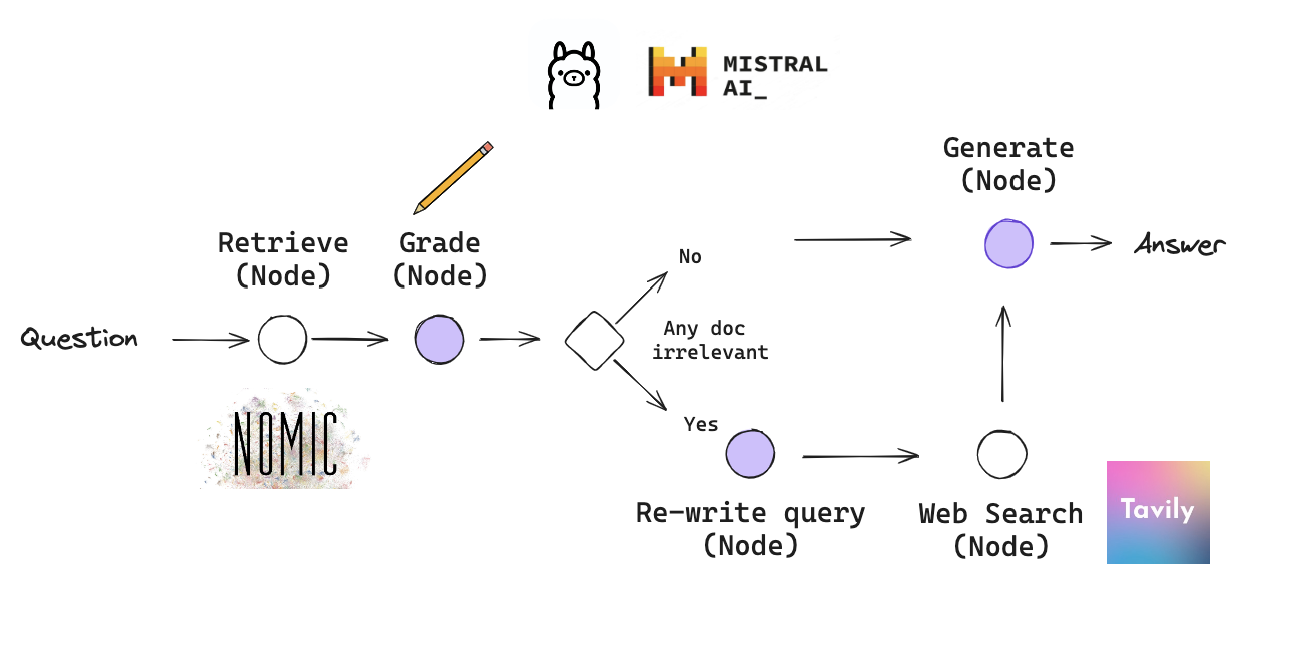

## Running

This notebook can be run three ways:

(1) Mistral API

(2) Locally 

(3) CoLab: [here](https://colab.research.google.com/drive/1U5OcwWjoXZSud30q4XOk1UlIJNjaD3kX?usp=sharing) is a link to a CoLab for this notebook. 

# Environment 

In [ ]:
! pip install --quiet langchain_community tiktoken langchainhub chromadb langchain langgraph tavily-python langchain-mistralai gpt4all

### LLMs

You can run this in two ways:

(1) Use [Mistral API](https://auth.mistral.ai/ui/login?flow=cc5d3fa5-122b-4c87-bcd8-81e8151c6753).

(2) Run locally, as shown below.

#### Local Embeddings

You can use `GPT4AllEmbeddings()` from Nomic, which can access use Nomic's recently released [v1](https://blog.nomic.ai/posts/nomic-embed-text-v1) and [v1.5](https://blog.nomic.ai/posts/nomic-embed-matryoshka) embeddings.


Follow the documentation [here](https://docs.gpt4all.io/gpt4all_python_embedding.html#supported-embedding-models).

#### Local LLM

(1) Download [Ollama app](https://ollama.ai/).

(2) Download a `Mistral` model from various Mistral versions [here](https://ollama.ai/library/mistral) and Mixtral versions [here](https://ollama.ai/library/mixtral) available.
```
ollama pull mistral
```

In [ ]:
# If using Mistral API
mistral_api_key =  <your-api-key>

### Search
 
We'll use [Tavily Search](https://python.langchain.com/docs/integrations/tools/tavily_search) for web search.

In [ ]:
import os
os.environ['TAVILY_API_KEY'] = <your-api-key>

### Tracing

Optionally, use [LangSmith](https://docs.smith.langchain.com/) for tracing (shown at bottom)

In [ ]:
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = <your-api-key>

## Configuration

Decide to run locally and select LLM to use with Ollama.

In [2]:
run_local = "Yes"
local_llm = "mistral:latest"

## Index

Let's index 3 blog posts.

In [3]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_nomic.embeddings import NomicEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_mistralai import MistralAIEmbeddings

# Load
url = "https://lilianweng.github.io/posts/2023-06-23-agent/"
loader = WebBaseLoader(url)
docs = loader.load()

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=100
)
all_splits = text_splitter.split_documents(docs)

# Embed and index
if run_local == "Yes":
    embedding=NomicEmbeddings(model="nomic-embed-text-v1.5",
                              inference_mode='local',)
else:
    embedding = MistralAIEmbeddings(mistral_api_key=mistral_api_key)

# Index
vectorstore = Chroma.from_documents(
    documents=all_splits,
    collection_name="rag-chroma",
    embedding=embedding,
)
retriever = vectorstore.as_retriever()

## LLMs

In [4]:
### Retrieval Grader

from langchain.prompts import PromptTemplate
from langchain_community.chat_models import ChatOllama
from langchain_mistralai.chat_models import ChatMistralAI
from langchain_core.output_parsers import JsonOutputParser

# LLM
if run_local == "Yes":
    llm = ChatOllama(model=local_llm, format="json", temperature=0)
else:
    llm = ChatMistralAI(
        model="mistral-medium", temperature=0, mistral_api_key=mistral_api_key
    )

prompt = PromptTemplate(
    template="""You are a grader assessing relevance of a retrieved document to a user question. \n 
    Here is the retrieved document: \n\n {document} \n\n
    Here is the user question: {question} \n
    If the document contains keywords related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
    Provide the binary score as a JSON with a single key 'score' and no premable or explanation.""",
    input_variables=["question", "document"],
)

retrieval_grader = prompt | llm | JsonOutputParser()
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

{'score': 'yes'}


In [6]:
### Generate

from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# LLM
if run_local == "Yes":
    llm = ChatOllama(model=local_llm, temperature=0)
else:
    llm = ChatMistralAI(
        model="mistral-medium", temperature=0, mistral_api_key=mistral_api_key
    )


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

 The given text discusses the concept of building autonomous agents using a large language model (LLM) as its core controller. The text highlights several key components of an LLM-powered agent system, including observation, retrieval, reflection, planning & reacting, and relationships between agents. It also mentions some challenges such as finite context length, long-term planning and task decomposition, and reliability of natural language interface. The text provides examples of proof-of-concept demos like AutoGPT and discusses their limitations. The architecture of the generative agent is also described, which results in emergent social behavior.


In [9]:
### Question Re-writer

# LLM
if run_local == "Yes":
    llm = ChatOllama(model=local_llm, temperature=0)
else:
    llm = ChatMistralAI(
        model="mistral-medium", temperature=0, mistral_api_key=mistral_api_key
    )

# Prompt
re_write_prompt = PromptTemplate(
    template="""You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the initial and formulate an improved question. \n
     Here is the initial question: \n\n {question}. Improved question with no preamble: \n """,
    input_variables=["generation", "question"],
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})

' What is agent memory and how can it be effectively utilized in vector database retrieval?'

## Web Search Tool

In [10]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

# Graph 

Capture the flow in as a graph.

## Graph state

In [11]:
from typing_extensions import TypedDict
from typing import List


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    web_search: str
    documents: List[str]

In [15]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:ß
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.get_relevant_documents(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score["score"]
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "question": question, "web_search": web_search}


def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)

    return {"documents": documents, "question": question}


### Edges


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform_query"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

## Build Graph

This just follows the flow we outlined in the figure above.

In [16]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform_query", transform_query)  # transform_query
workflow.add_node("web_search_node", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "web_search_node")
workflow.add_edge("web_search_node", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

In [17]:
from pprint import pprint

# Run
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
"Node 'grade_documents':"
'\n---\n'
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
"Node 'generate':"
'\n---\n'
"Node '__end__':"
'\n---\n'
(' The given text discusses the concept of building autonomous agents using '
 'large language models (LLMs) as their core controllers. LLMs have the '
 'potential to be powerful general problem solvers, extending beyond '
 'generating well-written copies, stories, essays, and programs. In an '
 "LLM-powered agent system, the model functions as the agent's brain, "
 'complemented by several key components: planning, memory, and tool use.\n'
 '\n'
 '1. Planning: The agent breaks down large tasks into smaller subgoals for '
 'efficient handling of complex tasks and can do self-criticism and '
 'self-reflection to improve

Trace: 

https://smith.langchain.com/public/731df833-57de-4612-8fe8-07cb424bc9a6/r

In [18]:
from pprint import pprint

# Run
inputs = {"question": "How does the AlphaCodium paper work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
"Node 'grade_documents':"
'\n---\n'
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
---TRANSFORM QUERY---
"Node 'transform_query':"
'\n---\n'
---WEB SEARCH---
"Node 'web_search_node':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
"Node '__end__':"
'\n---\n'
(' AlphaCodium is a new approach to code generation by LLMs, proposed in a '
 'paper titled "Code Generation with AlphaCodium: From Prompt Engineering to '
 'Flow Engineering." It\'s described as a test-based, multi-stage flow that '
 'improves the performance of LLMs on code problems without requiring '
 'fine-tuning. The iterative process involves repeatedly running and fixing '
 'generated code against input-output tests, with two key elemen

Trace: 

https://smith.langchain.com/public/c8b75f1b-38b7-48f2-a399-7ebb969d34f6/r